In [14]:
# --------------------------------------------------
# Import Libraries and Set Up Environment
# --------------------------------------------------
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# Enable inline plotting
%matplotlib inline

# matplotlib.use('Agg')  # Use 'Agg' backend

# Set joblib temporary directory
# os.environ['JOBLIB_TEMP_FOLDER'] = '/home/nrelab-titan/Desktop/shovon/temp_joblib' # Titan PC
os.environ['JOBLIB_TEMP_FOLDER'] = '/home/shovon/Desktop/temp_joblib' # Asus Laptop

In [9]:
# --------------------------------------------------
# Load and Prepare Data
# --------------------------------------------------
# File paths
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/plain_terrain_features.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/grass_terrain_features.csv'

# Noisy csv files' directory
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/plain_terrain_features_10_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/grass_terrain_features_10_mm.csv'

# 20 mm noise
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/plain_terrain_features_20_mm.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/grass_terrain_features_20_mm.csv'

# ----------------------------------------------------------------------------------------------------------------------------
# Load Features saved in csv files on Asus Laptop
# ----------------------------------------------------------------------------------------------------------------------------
# Cyglidar Data
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/cyglidar_plain_terrain_features.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/cyglidar_grass_terrain_features.csv'


# RoboSense Data
# ---------------------------------------------------------------------------------
# With No Noise
plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_no_noise.csv'
grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_no_noise.csv'

# 4 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_4_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_4_mm.csv'

# # 6 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_6_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_6_mm.csv'

# # 8 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_8_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_8_mm.csv'

# # 10 mm
# plain_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_10_mm.csv'
# grass_terrain_file = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_10_mm.csv'
# ----------------------------------------------------------------------------------------------------------------------------

# Load CSV files with specific encoding
# plain_terrain_df = pd.read_csv(plain_terrain_file, encoding='ISO-8859-1', on_bad_lines='skip')
# grass_terrain_df = pd.read_csv(grass_terrain_file, encoding='ISO-8859-1', on_bad_lines='skip')

# # Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

# Drop rows with NaN values
# plain_terrain_df.dropna(inplace=True)
# grass_terrain_df.dropna(inplace=True)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  2.85458 -0.580835 -0.652119  0.045347 -0.064117  0.996912    36.5000  plain
1  2.92749 -0.563877 -0.655366  0.048424 -0.062766  0.996853    36.7692  plain
2  2.99191 -0.531252 -0.657093  0.049972 -0.061263  0.996870    36.0000  plain
3  2.95937 -0.503874 -0.652745  0.048424 -0.062766  0.996853    33.0000  plain
4  2.99555 -0.510915 -0.656905  0.048170 -0.062950  0.996854    35.0000  plain


In [18]:
# --------------------------------------------------
# Feature Extraction and Scaling
# --------------------------------------------------
# Features and labels
features = ['NormalX', 'NormalY']
X = combined_df[features]
y = combined_df['label'].map({'plain': 0, 'grass': 1})

# Set the percentage of the dataset to use for training
train_percentage = 0.999  # 0.1 = 10%

# Split the data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=train_percentage, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_rest_scaled = scaler.transform(X_rest)

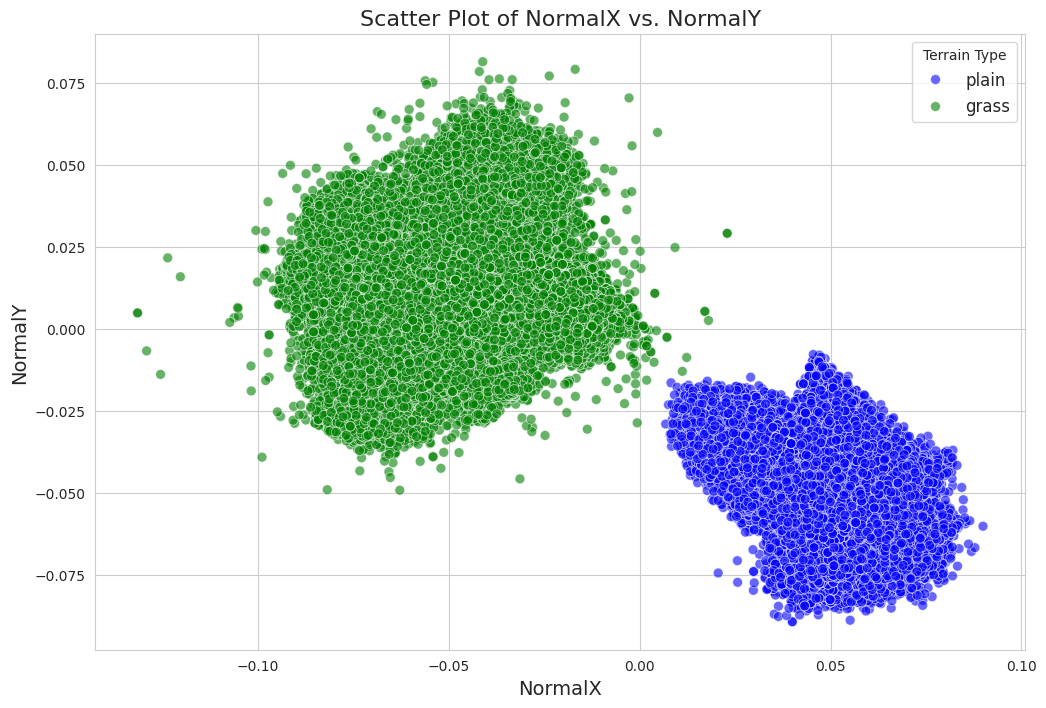

In [11]:
# --------------------------------------------------
# Feature Visualization before Model Training
# --------------------------------------------------
# Set the style for the plot
sns.set_style('whitegrid')

# Create a scatter plot of NormalX vs. NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette={'plain': 'blue', 'grass': 'green'}, alpha=0.6, s=50)

# Add plot details
plt.title('Scatter Plot of NormalX vs. NormalY', fontsize=16)
plt.xlabel('NormalX', fontsize=14)
plt.ylabel('NormalY', fontsize=14)
plt.legend(title='Terrain Type', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [19]:
# --------------------------------------------------
# Model Training and Cross-Validation
# --------------------------------------------------
# Initialize the SVM model with specified parameters
# svm_model = SVC(kernel='rbf', C=100, gamma=0.1, verbose=True)

# Linear kernel
svm_model = SVC(kernel='linear', C=100, verbose=True)  # Use 'linear' kernel instead of 'rbf'

# Perform 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function for parallel cross-validation prediction
def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
    with parallel_backend('loky'):
        return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# Using parallel processing for cross_val_predict
y_pred = parallel_cross_val_predict(svm_model, X_train_scaled, y_train, skf)
y_decision = parallel_cross_val_predict(svm_model, X_train_scaled, y_train, skf, method='decision_function')

# Calculate accuracy metrics
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)

# Display metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Generate a detailed classification report
class_report = classification_report(y_train, y_pred, target_names=['plain', 'grass'])
print("Classification Report:")
print(class_report)

# print(f"Length of y_train: {len(y_train)}")
# print(f"Length of y_pred: {len(y_pred)}")
# print(f"Length of y_decision: {len(y_decision)}")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]*
optimization finished, #iter = 26
obj = -483.168049, rho = 6.037319
nSV = 6, nBSV = 4
Total nSV = 6
**
optimization finished, #iter = 32

optimization finished, #iter = 25
obj = -373.255347, rho = 5.095008
obj = -287.150824, rho = 7.183870
nSV = 6, nBSV = 4
nSV = 6, nBSV = 4
Total nSV = 6
Total nSV = 6
*
optimization finished, #iter = 30
obj = -483.168049, rho = 6.037319
nSV = 6, nBSV = 4
Total nSV = 6
*
optimization finished, #iter = 694
obj = -270.207002, rho = 5.882828
nSV = 5, nBSV = 2
Total nSV = 5
[LibSVM][LibSVM][LibSVM]*
optimization finished, #iter = 32
obj = -373.255347, rho = 5.095008
nSV = 6, nBSV = 4
Total nSV = 6
*
optimization finished, #iter = 25
obj = -287.150824, rho = 7.183870
nSV = 6, nBSV = 4
Total nSV = 6
*
optimization finished, #iter = 26
obj = -483.168049, rho = 6.037319
nSV = 6, nBSV = 4
Total nSV = 6
[LibSVM][LibSVM]*
optimization finished, #iter = 30
obj = -483.168049, rho = 6.037319
nSV = 6, nBSV = 4
Total nSV = 6
*

In [20]:
# --------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------
# Calculate metrics
accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_decision)

# Compute TPR, FPR
fpr, tpr, thresholds = roc_curve(y_train, y_decision)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_value = fp / (fp + tn)  # False Positive Rate

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {roc_auc}")
print(f"TPR: {tpr_value}")
print(f"FPR: {fpr_value}")
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_train, y_pred, target_names=['plain', 'grass']))


Accuracy: 0.999992650373361
F1 Score: 0.9999940416725424
Precision: 0.9999960277738056
Recall: 0.9999920555791681
AUC: 0.9999999997206871
TPR: 0.9999920555791681
FPR: 6.3924313612682584e-06

Confusion Matrix:
[[156434      1]
 [     2 251747]]

Classification Report:
              precision    recall  f1-score   support

       plain       1.00      1.00      1.00    156435
       grass       1.00      1.00      1.00    251749

    accuracy                           1.00    408184
   macro avg       1.00      1.00      1.00    408184
weighted avg       1.00      1.00      1.00    408184



In [17]:
# --------------------------------------------------
# Train on Clean Data and Test on Clean and Noisy Data
# --------------------------------------------------

svm_model.fit(X_train_scaled, y_train)  # Fit the model on the entire clean training data

# Load the noisy data (10mm Gaussian noise)
plain_terrain_file_noisy = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/plain_terrain_features_10_mm.csv'
grass_terrain_file_noisy = '/home/shovon/Desktop/catkin_ws/src/stat_analysis/features_csv_files/grass_terrain_features_10_mm.csv'

# Load the noisy data into DataFrames
plain_terrain_df_noisy = pd.read_csv(plain_terrain_file_noisy)
grass_terrain_df_noisy = pd.read_csv(grass_terrain_file_noisy)

# Add labels to noisy data
plain_terrain_df_noisy['label'] = 'plain'
grass_terrain_df_noisy['label'] = 'grass'

# Concatenate the noisy DataFrames
combined_df_noisy = pd.concat([plain_terrain_df_noisy, grass_terrain_df_noisy], ignore_index=True)

# Drop rows with NaN values if necessary
combined_df_noisy.dropna(inplace=True)

# Test data (features and labels)
X_noisy = combined_df_noisy[features]
y_noisy = combined_df_noisy['label'].map({'plain': 0, 'grass': 1})

# Standardize noisy data using the same scaler fitted on clean training data
X_noisy_scaled = scaler.transform(X_noisy)

# Evaluate the model on clean and noisy datasets
y_noisy_pred = svm_model.predict(X_noisy_scaled)

# --------------------------------------------------
# Evaluate Metrics for Noisy Test Data
# --------------------------------------------------
print("Results for Noisy Test Data:")
accuracy_noisy = accuracy_score(y_noisy, y_noisy_pred)
f1_noisy = f1_score(y_noisy, y_noisy_pred)
precision_noisy = precision_score(y_noisy, y_noisy_pred)
recall_noisy = recall_score(y_noisy, y_noisy_pred)
conf_matrix_noisy = confusion_matrix(y_noisy, y_noisy_pred)

# Display metrics
print(f"Accuracy (Noisy): {accuracy_noisy:.4f}")
print(f"F1 Score (Noisy): {f1_noisy:.4f}")
print(f"Precision (Noisy): {precision_noisy:.4f}")
print(f"Recall (Noisy): {recall_noisy:.4f}")
print("Confusion Matrix (Noisy):")
print(conf_matrix_noisy)

# Generate and print a detailed classification report
class_report_noisy = classification_report(y_noisy, y_noisy_pred, target_names=['plain', 'grass'])
print("\nClassification Report (Noisy Data):")
print(class_report_noisy)


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

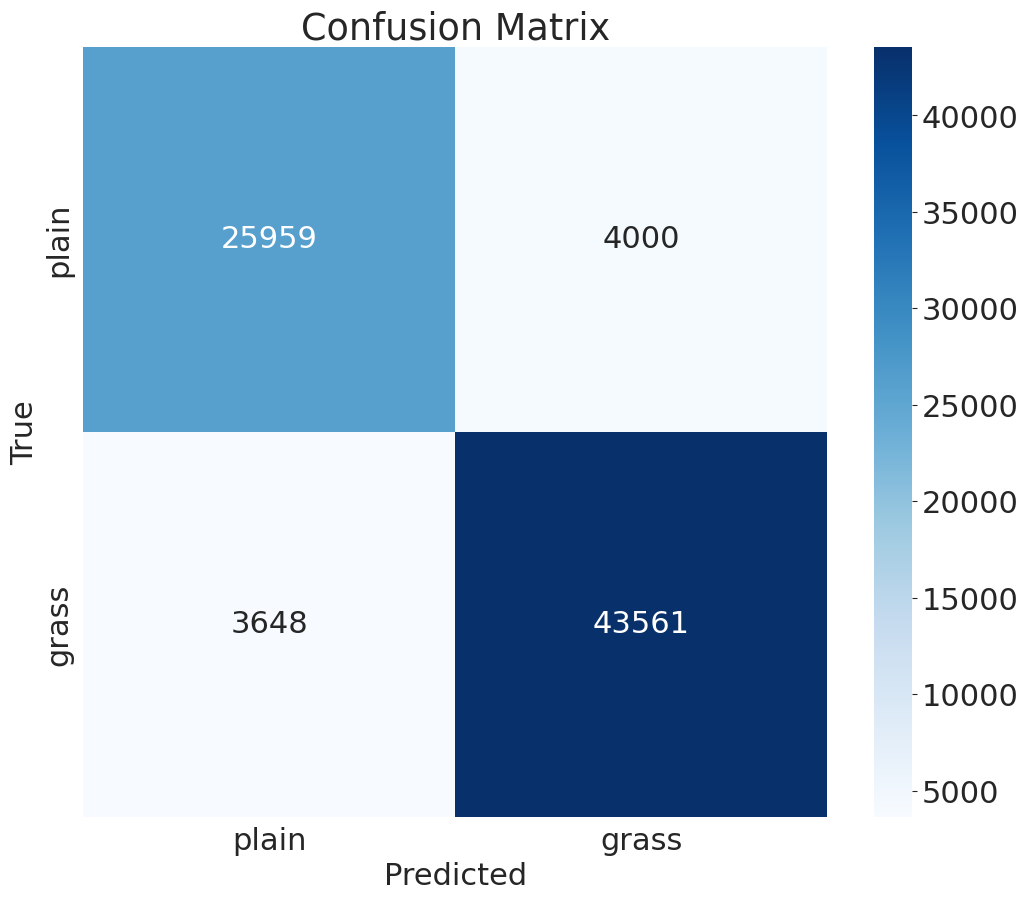

In [ ]:
# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------

# Set the directory where you want to save the plots
# plot_save_dir = '/home/nrelab-titan/Desktop/shovon/plots/'

# Ensure the directory exists
# os.makedirs(plot_save_dir, exist_ok=True)

# Increase text size for plots
plt.rcParams.update({'font.size': 22})

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# confusion_matrix_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
# plt.savefig(confusion_matrix_path)

# Show the plot
plt.show()

# print(f"Confusion matrix plot saved to: {confusion_matrix_path}")

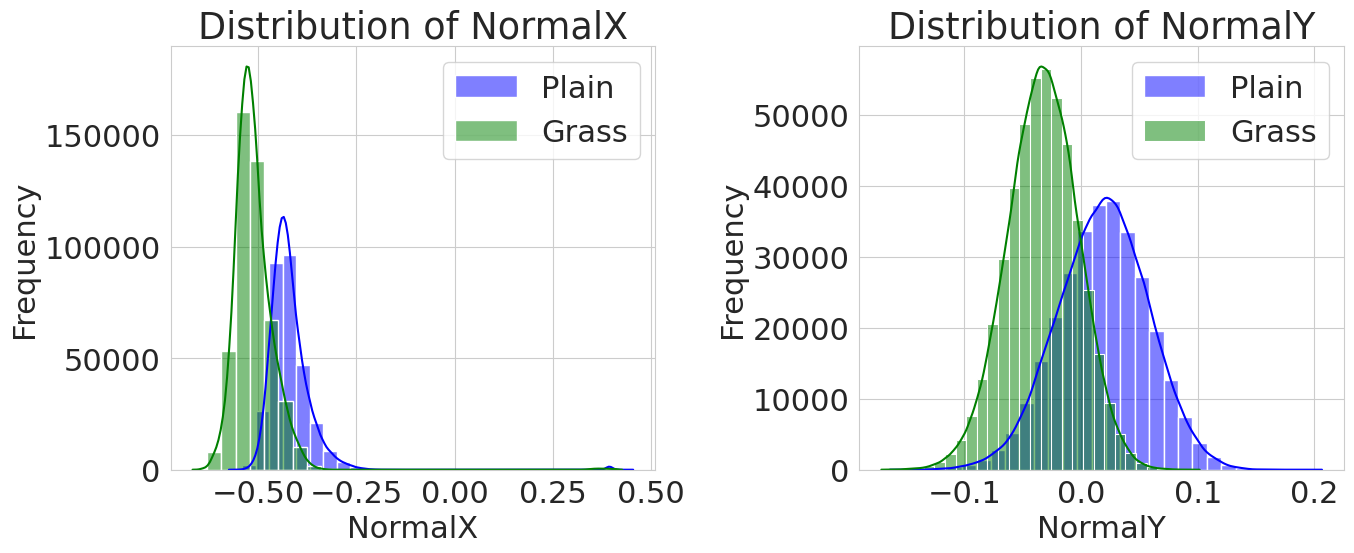

In [ ]:
# Plot side by side histograms for NormalX
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(plain_terrain_df['NormalX'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalX'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalX')
plt.xlabel('NormalX')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot side by side histograms for NormalY
plt.subplot(1, 2, 2)
sns.histplot(plain_terrain_df['NormalY'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalY'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalY')
plt.xlabel('NormalY')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
